Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from evojax.util import get_params_format_fn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
#jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "highest")

Problem: Navier-Stokes Equation

        u*u_x + v*u_y - 1/Re*(u_xx+u_yy) + p_x = 0
        v*v_x + v*v_y - 1/Re*(v_xx+v_yy) + p_y = 0
        u_x + v_y = 0

DNN / PINN   

In [2]:
class PINN(nn.Module):
    global nn_acf
    nn_acf = nn.silu
    
    """PINNs"""
    n_nodes: int    
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 2, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerp = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]     

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_uvp(x, y):
            inputs = jnp.hstack([x / 5., y / 2., (x - 1.) / 5., (x - 1.5) / 5., (x - 2.5) / 5., (y + 0.2) / 2.])
            # feature mapping
            hidden = self.feats(inputs)
            hidden = jnp.sin(jnp.pi*hidden)
            # hidden = jnp.sin(hidden)

            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)  
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)   
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            return (u, v, p)  
    
        u, v, p = get_uvp(x, y)

        def get_uvp_xy(get_uvp, x, y):
            u_x, v_x, p_x = jacfwd(get_uvp)(x, y)
            u_y, v_y, p_y = jacfwd(get_uvp, argnums=1)(x, y)

            return u_x, u_y, v_x, v_y, p_x , p_y
            
        get_uvp_xy_vmap = vmap(get_uvp_xy, in_axes=(None, 0, 0))
        u_x, u_y, v_x, v_y, p_x , p_y = get_uvp_xy_vmap(get_uvp, x, y)
        u_x, u_y, v_x, v_y, p_x , p_y = u_x[:,:,0], u_y[:,:,0], v_x[:,:,0], v_y[:,:,0], p_x[:,:,0] , p_y[:,:,0]

       # obtain u_xx, u_yy, v_xx, v_yy, p_xx, p_yy
        def get_uvp_xxyy(get_uvp, x, y):
            u_xx, v_xx, p_xx = jacfwd(jacfwd(get_uvp))(x, y)
            u_yy, v_yy, p_yy = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(x, y)

            return u_xx, u_yy, v_xx, v_yy, p_xx , p_yy
        
        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0))
        u_xx, u_yy, v_xx, v_yy, p_xx , p_yy = get_uvp_xxyy_vmap(get_uvp, x, y)
        u_xx, u_yy, v_xx, v_yy, p_xx , p_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0], p_xx[:,:,0,0] , p_yy[:,:,0,0]

        # obtain BC indices
        #nbc = (x != x_l) | (x != x_u) | (y != y_l) | (y != y_u)
        bc  = (x == x_l) | (x == x_u) | (y == y_l) | (y == y_u)
        nbc = (~bc)
        uv_bc = (x == x_l) | (y == y_l) | (y == y_u)
        p_bc = (x == x_u)

        # compute PDE residual : N-S equations
        # continuity = u_x + v_y
        # momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
        # momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)
        residuals_continuity = u_x + v_y
        residuals_momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
        residuals_momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)

        mom1 = -1.0/Re*(u_xx + u_yy)
        mom2 = -1.0/Re*(v_xx + v_yy)
        
        outputs = jnp.hstack([u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, u_y, uv_bc,p_bc, nbc, mom1, mom2])
        return outputs 


class DNN(nn.Module):
    global nn_acf
    nn_acf = nn.silu    
    """DNNs"""
    n_nodes: int
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 2, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerp = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]    

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_uvp(x, y):
            inputs = jnp.hstack([x / 5., y / 2., (x - 1.) / 5., (x - 1.5) / 5., (x - 2.5) / 5., (y + 0.2) / 2.])
            # feature mapping
            hidden = self.feats(inputs)
            # hidden = jnp.sin(hidden)
            hidden = jnp.sin(jnp.pi*hidden)

            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)  
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)   
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            return (u, v, p)  
            
        u, v, p = get_uvp(x, y)

        def get_uvp_xxyy(get_uvp, x, y):
            u_xx, v_xx, _ = jacfwd(jacfwd(get_uvp))(x, y)
            u_yy, v_yy, _ = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(x, y)

            return u_xx, u_yy, v_xx, v_yy
        
        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0))
        u_xx, u_yy, v_xx, v_yy, = get_uvp_xxyy_vmap(get_uvp, x, y)
        u_xx, u_yy, v_xx, v_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0]

        mom1 = -1.0/Re*(u_xx + u_yy)
        mom2 = -1.0/Re*(v_xx + v_yy)

        outputs = jnp.hstack([u, v, p, mom1, mom2])
        return outputs 


In [3]:
# compute thickness
def naca0012_thickness(x, thickness=0.12):
    return 5 * thickness * (0.2969 * np.sqrt(x) - 0.1260 * x - 
                            0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)

# sample points on airfoil
def sample_points_on_airfoil(num_points=100, thickness=0.12, equal_spacing=True):

    x_dense = np.linspace(0, 1, 1000)
    y_dense = naca0012_thickness(x_dense, thickness)
    
    # upper & lower
    x_upper, y_upper = x_dense[::-1], y_dense[::-1]
    x_lower, y_lower = x_dense[1:], -y_dense[1:]
    # both
    x_all, y_all = np.concatenate([x_upper, x_lower]), np.concatenate([y_upper, y_lower])
    
    # equal spacing
    if equal_spacing:
        ds = np.sqrt(np.diff(x_all)**2 + np.diff(y_all)**2)
        s = np.concatenate([[0], np.cumsum(ds)])
        total_length = s[-1]
        s_uniform = np.linspace(0, total_length, num_points)
        fx, fy = interp1d(s, x_all), interp1d(s, y_all)
        x_sampled, y_sampled = fx(s_uniform), fy(s_uniform)
    else:
        half_points = num_points // 2
        x_upper_sampled = np.linspace(0, 1, half_points)
        y_upper_sampled = naca0012_thickness(x_upper_sampled, thickness)
        x_lower_sampled, y_lower_sampled = x_upper_sampled, -y_upper_sampled
        x_sampled, y_sampled = np.concatenate([x_upper_sampled, x_lower_sampled]), np.concatenate([y_upper_sampled, y_lower_sampled])
    
    # rotate anti-clockwise
    theta = np.deg2rad(-7)
    x_center, y_center = 0.5, 0
    x_trans = x_sampled - x_center
    y_trans = y_sampled - y_center
    x_rot = x_trans * np.cos(theta) - y_trans * np.sin(theta)
    y_rot = x_trans * np.sin(theta) + y_trans * np.cos(theta)
    x_sampled = x_rot + x_center
    y_sampled = y_rot + y_center
    
    return x_sampled, y_sampled

In [4]:
def main(ER, ER_xx, weight_bc, batch, max_lr, exponent, max_iter, seed, gpu):

    global Re, x_l, x_u, y_l, y_u
    
    # parameter
    Re = 500

    sim = pd.read_csv('naca0012_two_RE500_1001x501.csv',sep='\\s+')
    sim_x, sim_y, sim_ls = sim['x'].values.reshape(-1,1), sim['y'].values.reshape(-1,1), sim['phi'].values.reshape(-1,1) 
    sim_u, sim_v, sim_p = sim['u'].values.reshape(-1,1), sim['v'].values.reshape(-1,1), sim['p'].values.reshape(-1,1) 
    x_l, x_u, y_l, y_u = np.min(sim_x), np.max(sim_x), np.min(sim_y), np.max(sim_y)
    #ext = [x_l, x_u, y_l, y_u]
    #print (x_l, x_u, y_l, y_u)

    data_X, data_Y = np.hstack([sim_x, sim_y]), np.hstack([sim_u, sim_v, sim_p])

    dx = (np.unique(data_X[:,0])[1] - np.unique(data_X[:,0])[0])
    _inner = (sim_ls[:,0] <= 0.0) | ( abs(sim_ls[:,0] ) <= 0.1*dx)
    data_X, data_Y = data_X[_inner], data_Y[_inner]

    airfoil_x, airfoil_y = sample_points_on_airfoil(num_points=400, thickness=0.12, equal_spacing=True)
    airfoil_x, airfoil_y = airfoil_x.reshape(-1,1), airfoil_y.reshape(-1,1)
    airfoil_shape = np.hstack([airfoil_x, airfoil_y])
    airfoil_shape_value = np.zeros((len(airfoil_shape[:,0]), 3))
    
    x_air2, y_air2 = (max(airfoil_x) - min(airfoil_x)) + 0.5, - 0.2
    airfoil_x2, airfoil_y2 = airfoil_x + x_air2, airfoil_y + y_air2
    airfoil_shape2 = np.hstack([airfoil_x2, airfoil_y2])
    airfoil_shape_value2 = np.zeros((len(airfoil_shape2[:,0]),3))
    
    l_bc, r_bc, tb_bc = (data_X[:,0] == x_l), (data_X[:,0] == x_u), (data_X[:,1] == y_l) | (data_X[:,1] == y_u)
    data_X_l_BC, data_Y_l_BC = data_X[l_bc], data_Y[l_bc]
    data_X_r_BC, data_Y_r_BC = data_X[r_bc], data_Y[r_bc]
    data_X_tb_BC, data_Y_tb_BC = data_X[tb_bc], data_Y[tb_bc]
    data_X_airfoil_BC, data_Y_airfoil_BC = np.vstack([airfoil_shape, airfoil_shape2]), np.vstack([airfoil_shape_value, airfoil_shape_value2])

    # convert to jnp
    data_X, data_Y = jnp.array(data_X), jnp.array(data_Y) # flow domain
    data_X_l_BC, data_Y_l_BC = jnp.array(data_X_l_BC), jnp.array(data_Y_l_BC)
    data_X_r_BC, data_Y_r_BC = jnp.array(data_X_r_BC), jnp.array(data_Y_r_BC)
    data_X_tb_BC, data_Y_tb_BC = jnp.array(data_X_tb_BC), jnp.array(data_Y_tb_BC)
    data_X_airfoil_BC, data_Y_airfoil_BC = jnp.array(data_X_airfoil_BC), jnp.array(data_Y_airfoil_BC)

    BS_ALL = batch
    BS_l_BC, BS_r_BC, BS_tb_BC = int(len(data_X_l_BC)*0.1), int(len(data_X_r_BC)*0.1), int(len(data_X_tb_BC)*0.1)
    BS_airfoil_BC = int(len(data_X_airfoil_BC)*0.1)

    BS_PDE = BS_ALL - BS_l_BC - BS_r_BC - BS_tb_BC - BS_airfoil_BC  #- BS_interpolation # - BS_BC
    n_all, n_l_BC, n_r_BC, n_tb_BC, n_airfoil_BC  = len(data_X), len(data_X_l_BC), len(data_X_r_BC), len(data_X_tb_BC), len(data_X_airfoil_BC)
    print('The total number of samples:' ,n_all)
    print('BS_ALL:', BS_ALL, ' BS_PDE:',BS_PDE, ' BS_l_BC:',BS_l_BC, ' BS_r_BC:',BS_r_BC, ' BS_tb_BC:',BS_tb_BC, ' BS_airfoil_BC:',BS_airfoil_BC)

    # choose seed
    seed = seed
    key, rng = random.split(random.PRNGKey(seed))
    
    # dummy input
    a = random.normal(key, [1,2])
    
    # initialization call
    n_nodes = 32
    model, model_0 = PINN(n_nodes), DNN(n_nodes)
    params = model.init(key, a) 
    num_params, format_params_fn = get_params_format_fn(params)
    #print (num_params)
    
    # flatten initial params
    params = jax.flatten_util.ravel_pytree(params)[0]  
    
    params_0 = params 
    params_interp = params

    @jit
    def minibatch(key):
        key1, key2, key3, key4, key5, key6 = key
        batch_all = random.choice(key1, n_all , (BS_PDE,))
        batch_bc_l = random.choice(key2, n_l_BC, (BS_l_BC,))   
        batch_bc_r = random.choice(key3, n_r_BC, (BS_r_BC,))   
        batch_bc_tb = random.choice(key4, n_tb_BC, (BS_tb_BC,))   
        batch_bc_airfoil = random.choice(key5, n_airfoil_BC, (BS_airfoil_BC,))
        batch_X = jnp.vstack([data_X[batch_all], 
                              data_X_l_BC[batch_bc_l], 
                              data_X_r_BC[batch_bc_r],
                              data_X_tb_BC[batch_bc_tb],
                              data_X_airfoil_BC[batch_bc_airfoil]])
        batch_Y = jnp.vstack([data_Y[batch_all], 
                              data_Y_l_BC[batch_bc_l],
                              data_Y_r_BC[batch_bc_r], 
                              data_Y_tb_BC[batch_bc_tb],
                              data_Y_airfoil_BC[batch_bc_airfoil]])
        return (batch_X, batch_Y)

    def eval_loss(params,params_0, inputs, labels):
        pred = model.apply(format_params_fn(params), inputs)
        u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, u_y, uv_bc,p_bc, nbc, m_1, m_2 = jnp.split(pred, 12, axis=1)
        gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=1)
        x, y = jnp.split(inputs, 2 , axis=1)
        # stable evolution
        pred0 = model_0.apply(format_params_fn(params_0), inputs)
        u_0, v_0, p_0, m0_1, m0_2 = jnp.split(pred0, 5, axis=1) 
        # PDE
        residuals_continuity = residuals_continuity + (p - p_0) / ER # ER @PDE
        residuals_momentum_1 = residuals_momentum_1 + (u - u_0) / ER + (m_1 - m0_1) / ER_xx # ER @PDE
        residuals_momentum_2 = residuals_momentum_2 + (v - v_0) / ER + (m_2 - m0_2) / ER_xx # ER @PDE
        pde_uvp  = jnp.square(residuals_continuity) + jnp.square(residuals_momentum_1) + jnp.square(residuals_momentum_2)
        pde_uvp, nbc = pde_uvp[:-BS_airfoil_BC], nbc[:-BS_airfoil_BC]  # remove airfoil points
        pde_loss = jnp.sum(pde_uvp*nbc) / nbc.sum()
    
        bc_u, bc_v = (u - gt_u), (v - gt_v)
        _tb = (y == y_l) | (y == y_u)
        bc_u = jnp.where(_tb, u_y, bc_u)
        bc_uv = jnp.square(bc_u) + jnp.square(bc_v)
        bc_uv_loss = jnp.sum(bc_uv*uv_bc) / uv_bc.sum()
        
        bc_p = (p)  # p_bc is the mask for p boundary condition
        bc_p_loss =  jnp.sum(jnp.square(bc_p)*p_bc) / p_bc.sum()  # p_bc is the mask for p boundary condition
        
        bc_u_airfoil, bc_v_airfoil = u[-BS_airfoil_BC:], v[-BS_airfoil_BC:]  # airfoil_BC is the mask for airfoil boundary condition
        bc_airfoil = jnp.mean(jnp.square(bc_u_airfoil)) + jnp.mean(jnp.square(bc_v_airfoil))  # airfoil_BC is the mask for airfoil boundary condition
        bc_loss = bc_uv_loss + bc_p_loss + bc_airfoil  # airfoil_BC is the mask for airfoil boundary condition
        
        loss = pde_loss + bc_loss*weight_bc
        gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
        V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
        mse_u = jnp.mean(jnp.square(u - gt_u)) 
        mse_v = jnp.mean(jnp.square(v - gt_v)) 
        mse_V = jnp.mean(jnp.square(V - gt_V))  # mean squared error of velocity magnitude
        l2_u = jnp.linalg.norm(u - gt_u) / jnp.linalg.norm(gt_u)
        l2_v = jnp.linalg.norm(v - gt_v) / jnp.linalg.norm(gt_v)
        l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
        
        return loss, (mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss)
    
    loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))    

    # weights update  
    @jit
    def update(params, params_0,opt_state, key):
        batch_X, batch_Y = minibatch(key)
        (loss, (mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss)), grad = loss_grad(params,params_0, batch_X, batch_Y)
        updates, opt_state = optimizer.update(grad, opt_state)
        params_0 = params # update u_0
        params = optax.apply_updates(params, updates)
        return params, params_0, opt_state, loss,mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss

    
    # optimizer
    max_iters = max_iter
    max_lr = max_lr
    lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=int(0.0*max_iters),  
                                                      decay_steps=max_iters, end_value=1e-10,exponent=exponent)
    optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
    opt_state = optimizer.init(params)

    # training iteration
    runtime = 0
    train_iters = 0
    
    store = []
    while (train_iters <= max_iters):
        # mini-batch update
        start = time.time()
        key1, key2, key3, key4, key5, key6, rng = random.split(rng, 7) # update random generator
        params, params_0, opt_state, loss, mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss = update(params,params_0, opt_state, (key1, key2,key3,key4,key5,key6))
        end = time.time()
        runtime += (end-start)    
        # append weights
        if (train_iters % 5000 == 0):
            print ('iter. = %05d,  time = %03ds,  loss = %.2e  |  mse_u = %.2e,  mse_v = %.2e,  rl2_u = %.2e,  rl2_v = %.2e'%(train_iters, runtime, loss, mse_u, mse_v, l2_u, l2_v))
            store.append([train_iters, runtime, loss, mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss])
        train_iters += 1
    
    store = jnp.array(store)

    """PINN solution"""
    # solution
    inputs, labels = data_X, data_Y
    uvp = model.apply(format_params_fn(params), inputs)
    u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, uv_bc,p_bc, nbc,res_u,res_v,fx,fy,mom_x_solid,mom_y_solild,res_fx,res_fy = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3], uvp[:,3:4], uvp[:,4:5], uvp[:,5:6], uvp[:,6:7], uvp[:,7:8], uvp[:,8:9], uvp[:,9:10], uvp[:,10:11], uvp[:,11:12], uvp[:,12:13], uvp[:,13:14], uvp[:,14:15],uvp[:,15:16],uvp[:,16:17]
    gt_u, gt_v,gt_p = jnp.split(labels, 3, axis=-1)
    gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
    V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
    # errors
    mse_u = jnp.mean(jnp.square(u - gt_u)) 
    mse_v = jnp.mean(jnp.square(v - gt_v)) 
    mse_V = jnp.mean(jnp.square(V - gt_V)) 
    mse_p = jnp.mean(jnp.square(p - gt_p))  # mean squared error of pressure
    l2_u = jnp.linalg.norm(u - gt_u) / jnp.linalg.norm(gt_u)
    l2_v = jnp.linalg.norm(v - gt_v) / jnp.linalg.norm(gt_v)
    l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
    l2_p = jnp.linalg.norm(p - gt_p) / jnp.linalg.norm(gt_p)  # relative l2 error of pressure
    print ('[FULLDOM] : mse_V = %.2e, rl2_V = %.2e'%(mse_V, l2_V))

    # inner domain
    _small = (data_X[:,0] <= 2.55) & (data_X[:,0] >= -0.05) & (data_X[:,1] <= 0.2) & (data_X[:,1] >= -0.4)
    data_X, data_Y = data_X[_small], data_Y[_small]
    inputs, labels = data_X, data_Y
    uvp = model.apply(format_params_fn(params), inputs)
    u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, uv_bc,p_bc, nbc,res_u,res_v,fx,fy,mom_x_solid,mom_y_solild,res_fx,res_fy = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3], uvp[:,3:4], uvp[:,4:5], uvp[:,5:6], uvp[:,6:7], uvp[:,7:8], uvp[:,8:9], uvp[:,9:10], uvp[:,10:11], uvp[:,11:12], uvp[:,12:13], uvp[:,13:14], uvp[:,14:15],uvp[:,15:16],uvp[:,16:17]
    gt_u, gt_v,gt_p = jnp.split(labels, 3, axis=-1)
    gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
    V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
    # errors
    mse_u = jnp.mean(jnp.square(u - gt_u)) 
    mse_v = jnp.mean(jnp.square(v - gt_v)) 
    mse_V = jnp.mean(jnp.square(V - gt_V)) 
    mse_p = jnp.mean(jnp.square(p - gt_p))  # mean squared error of pressure
    l2_u = jnp.linalg.norm(u - gt_u) / jnp.linalg.norm(gt_u)
    l2_v = jnp.linalg.norm(v - gt_v) / jnp.linalg.norm(gt_v)
    l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
    l2_p = jnp.linalg.norm(p - gt_p) / jnp.linalg.norm(gt_p)  # relative l2 error of pressure
    print ('[COMPACT] : mse_V = %.2e, rl2_V = %.2e'%(mse_V, l2_V))
    
    params_ = format_params_fn(params[:])
    
    return params_, u, v, p


In [22]:
params, u, v, p = main(ER=0.05, ER_xx=1, weight_bc=5, batch=4000,
                       max_lr=5e-3, exponent=1.2, max_iter=50000, seed=40, gpu=1)

The total number of samples: 499912
BS_ALL: 4000  BS_PDE: 3620  BS_l_BC: 50  BS_r_BC: 50  BS_tb_BC: 200  BS_airfoil_BC: 80
iter. = 00000,  time = 009s,  loss = 8.09e+00  |  mse_u = 6.77e-01,  mse_v = 5.57e-01,  rl2_u = 8.20e-01,  rl2_v = 3.33e+01
iter. = 05000,  time = 027s,  loss = 3.08e-02  |  mse_u = 5.36e-03,  mse_v = 4.03e-04,  rl2_u = 7.29e-02,  rl2_v = 8.13e-01
iter. = 10000,  time = 044s,  loss = 9.94e-02  |  mse_u = 2.80e-03,  mse_v = 3.60e-04,  rl2_u = 5.28e-02,  rl2_v = 6.77e-01
iter. = 15000,  time = 061s,  loss = 9.33e-03  |  mse_u = 2.24e-03,  mse_v = 1.11e-04,  rl2_u = 4.71e-02,  rl2_v = 4.71e-01
iter. = 20000,  time = 078s,  loss = 1.69e-02  |  mse_u = 1.39e-03,  mse_v = 8.59e-05,  rl2_u = 3.72e-02,  rl2_v = 3.54e-01
iter. = 25000,  time = 096s,  loss = 3.11e-02  |  mse_u = 1.40e-03,  mse_v = 1.19e-04,  rl2_u = 3.74e-02,  rl2_v = 4.31e-01
iter. = 30000,  time = 113s,  loss = 1.14e-02  |  mse_u = 9.16e-04,  mse_v = 6.59e-05,  rl2_u = 3.02e-02,  rl2_v = 3.32e-01
iter. = 3

Airfoil

In [23]:
sim = pd.read_csv('naca0012_two_RE500_1001x501.csv',sep='\\s+')
sim_x, sim_y, sim_ls = sim['x'].values.reshape(-1,1), sim['y'].values.reshape(-1,1), sim['phi'].values.reshape(-1,1) 
sim_u, sim_v, sim_p = sim['u'].values.reshape(-1,1), sim['v'].values.reshape(-1,1), sim['p'].values.reshape(-1,1) 
x_l, x_u, y_l, y_u = np.min(sim_x), np.max(sim_x), np.min(sim_y), np.max(sim_y)

data_X, data_Y = np.hstack([sim_x, sim_y]), np.hstack([sim_u, sim_v, sim_p])

dx = (np.unique(data_X[:,0])[1] - np.unique(data_X[:,0])[0])
_inner = (sim_ls[:,0] <= 0.0) | ( abs(sim_ls[:,0] ) <= 0.1*dx)
data_X, data_Y = data_X[_inner], data_Y[_inner]

airfoil_x, airfoil_y = sample_points_on_airfoil(num_points=400, thickness=0.12, equal_spacing=True)
airfoil_x, airfoil_y = airfoil_x.reshape(-1,1), airfoil_y.reshape(-1,1)
    
x_air2, y_air2 = (max(airfoil_x) - min(airfoil_x)) + 0.5, - 0.2
airfoil_x2, airfoil_y2 = airfoil_x + x_air2, airfoil_y + y_air2

data_airfoli_bc_xy = jnp.hstack([airfoil_x, airfoil_y])
data_airfoli_bc_xy2 = jnp.hstack([airfoil_x2, airfoil_y2])

# model
model = DNN(32)

# solution
uvp_airfoil = model.apply(params, data_airfoli_bc_xy)
u_arifol, v_arifol, p_arifol = uvp_airfoil[:,0:1], uvp_airfoil[:,1:2], uvp_airfoil[:,2:3]

uvp_airfoil2 = model.apply(params, data_airfoli_bc_xy2)
u_arifol2, v_arifol2, p_arifol2 = uvp_airfoil2[:,0:1], uvp_airfoil2[:,1:2], uvp_airfoil2[:,2:3]

In [24]:
sim_cp = pd.read_csv('naca0012_atk7_two_Cp_UP.csv',sep='\\s+')
sim_cp_x = sim_cp['x'].values.reshape(-1,1)
sim_cp_p = sim_cp['p'].values.reshape(-1,1)
sim_cp = pd.read_csv('naca0012_atk7_two_Cp_LOW.csv',sep='\\s+')
sim_cp_x = np.vstack([sim_cp_x, sim_cp['x'].values.reshape(-1,1)])
sim_cp_p = np.vstack([sim_cp_p, sim_cp['p'].values.reshape(-1,1)])

sim_cp2 = pd.read_csv('naca0012_atk7_two_Cp_UP2.csv',sep='\\s+')
sim_cp_x2 = sim_cp2['x'].values.reshape(-1,1)
sim_cp_p2 = sim_cp2['p'].values.reshape(-1,1)
sim_cp2 = pd.read_csv('naca0012_atk7_two_Cp_LOW2.csv',sep='\\s+')
sim_cp_x2 = np.vstack([sim_cp_x2, sim_cp2['x'].values.reshape(-1,1)])
sim_cp_p2 = np.vstack([sim_cp_p2, sim_cp2['p'].values.reshape(-1,1)])

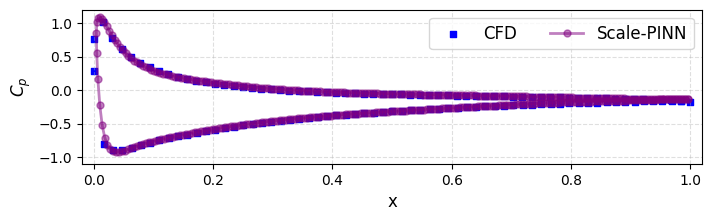

In [25]:
plt.figure(figsize=(8, 2))
plt.scatter(sim_cp_x[::20], sim_cp_p[::20]*2, s=20, c='blue', marker='s', alpha=1., label='CFD')
plt.plot(data_airfoli_bc_xy[:,0], p_arifol*2, '-o', color='purple', linewidth=2, markersize=5, alpha=0.5, label='Scale-PINN')
plt.xlim(-0.02, 1.02); plt.ylim(-1.1, 1.2); plt.legend(fontsize='large', ncol=2);
plt.xlabel('x', fontsize='large'); plt.ylabel('$C_p$', fontsize='large');
plt.grid(True, linestyle='--', alpha=0.4);

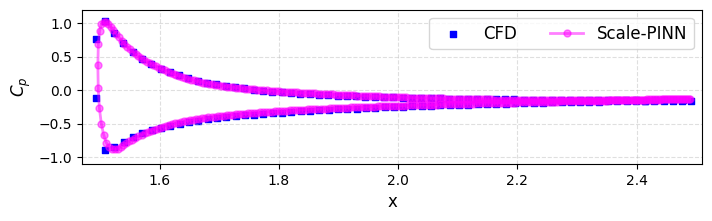

In [26]:
plt.figure(figsize=(8, 2))
plt.scatter(sim_cp_x2[::20] + x_air2, sim_cp_p2[::20]*2, s=20, c='blue', marker='s', alpha=1., label='CFD')
plt.plot(data_airfoli_bc_xy2[:,0], p_arifol2*2, '-o', color='magenta', linewidth=2, markersize=5, alpha=0.5, label='Scale-PINN')
plt.xlim(1.47, 2.51); plt.ylim(-1.1, 1.2); plt.legend(fontsize='large', ncol=2);
plt.xlabel('x', fontsize='large'); plt.ylabel('$C_p$', fontsize='large');
plt.grid(True, linestyle='--', alpha=0.4);

Near field

In [27]:
def rotate_point(x, y, angle_deg, center_x=0.5, center_y=0):
    x_translated = x - center_x
    y_translated = y - center_y
    angle_rad = np.radians(angle_deg)
    x_rot = x_translated * np.cos(angle_rad) - y_translated * np.sin(angle_rad)
    y_rot = x_translated * np.sin(angle_rad) + y_translated * np.cos(angle_rad)
    x_rot += center_x
    y_rot += center_y
    return x_rot, y_rot

In [28]:
# foil location
naca0012_x_num = 100
naca0012_x = jnp.linspace(0, 1, naca0012_x_num).reshape(-1,1)
y_t = naca0012_thickness(naca0012_x, thickness=0.12)
x_upper, y_upper = naca0012_x, +y_t
x_lower, y_lower = naca0012_x, -y_t
naca0012_x_rot, y_upper_rot = rotate_point(naca0012_x,y_upper, -7)
naca0012_x_rot, y_lower_rot = rotate_point(naca0012_x,y_lower, -7)
naca0012_x_rot2, y_upper_rot2 = naca0012_x_rot +x_air2, y_upper_rot +y_air2
naca0012_x_rot2, y_lower_rot2 = naca0012_x_rot +x_air2, y_lower_rot +y_air2

In [29]:
sim = pd.read_csv('naca0012_two_RE500_1001x501.csv',sep='\\s+')
sim_x, sim_y, sim_ls = sim['x'].values.reshape(-1,1), sim['y'].values.reshape(-1,1), sim['phi'].values.reshape(-1,1) 
sim_u, sim_v, sim_p = sim['u'].values.reshape(-1,1), sim['v'].values.reshape(-1,1), sim['p'].values.reshape(-1,1) 
x_l, x_u, y_l, y_u = np.min(sim_x), np.max(sim_x), np.min(sim_y), np.max(sim_y)

data_X, data_Y = np.hstack([sim_x, sim_y]), np.hstack([sim_u, sim_v, sim_p])
dx = (np.unique(data_X[:,0])[1] - np.unique(data_X[:,0])[0])
_inner = (sim_ls[:,0] <= 0.0) | ( abs(sim_ls[:,0] ) <= 0.1*dx)
data_X, data_Y = data_X[_inner], data_Y[_inner]

_small = (data_X[:,0] <= 3) & (data_X[:,0] >= -0.2) & (data_X[:,1] <= 0.25) & (data_X[:,1] >= -0.4)
data_X, data_Y = data_X[_small], data_Y[_small]
print (data_X.shape, data_Y.shape)

# model
model = DNN(32)

# solution
inputs, labels = data_X, data_Y
uvp = model.apply(params, inputs)
u, v, p= uvp[:,0:1], uvp[:,1:2], uvp[:,2:3]
gt_u, gt_v,gt_p = jnp.split(labels, 3, axis=-1)
gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
# errors
mse_V = jnp.mean(jnp.square(V - gt_V)) 
l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
print ('[Re=%d] : mse_V = %.2e, rl2_V = %.2e'%(Re, mse_V, l2_V))

(19597, 2) (19597, 3)
[Re=500] : mse_V = 2.33e-04, rl2_V = 1.96e-02


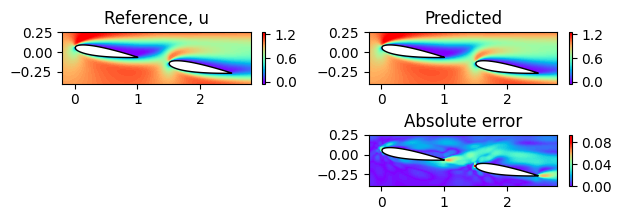

In [30]:
# plot
cfd, pinn = data_Y[:,0], u.flatten()
fig = plt.figure(figsize=(7, 2))
fig.subplots_adjust(wspace=.3, hspace=1.)
con_lv = 101
ax1 = fig.add_subplot(2,2,1)
plt.tricontourf(data_X[:,0], data_X[:,1], cfd, con_lv, origin='lower', cmap='rainbow', vmin=-0., vmax=1.2);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)  
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Reference, u');
plt.colorbar(ticks=[0., 0.6, 1.2]);
ax1 = fig.add_subplot(2,2,2)
plt.tricontourf(data_X[:,0], data_X[:,1], pinn, con_lv, origin='lower', cmap='rainbow', vmin=-0., vmax=1.2);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Predicted');
plt.colorbar(ticks=[0., 0.6, 1.2]);
ax1 = fig.add_subplot(2,2,4)
plt.tricontourf(data_X[:,0], data_X[:,1], abs(cfd - pinn), con_lv, origin='lower', cmap='rainbow', vmin=0, vmax=0.08);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)  
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Absolute error');
plt.colorbar(ticks=[0, 0.04, 0.08]);

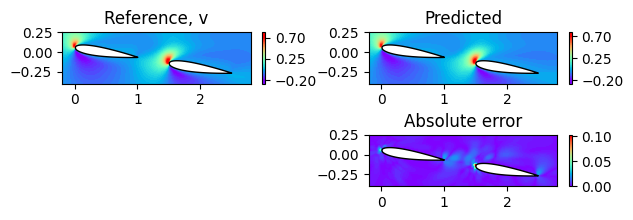

In [37]:
# plot
cfd, pinn = data_Y[:,1], v.flatten()
fig = plt.figure(figsize=(7, 2))
fig.subplots_adjust(wspace=.3, hspace=1.)
con_lv = 101
ax1 = fig.add_subplot(2,2,1)
plt.tricontourf(data_X[:,0], data_X[:,1], cfd, con_lv, origin='lower', cmap='rainbow', vmin=-0.2, vmax=0.7);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)  
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Reference, v');
plt.colorbar(ticks=[-0.2, 0.25, 0.7]);
ax1 = fig.add_subplot(2,2,2)
plt.tricontourf(data_X[:,0], data_X[:,1], pinn, con_lv, origin='lower', cmap='rainbow', vmin=-0.2, vmax=0.7);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Predicted');
plt.colorbar(ticks=[-0.2, 0.25, 0.7]);
ax1 = fig.add_subplot(2,2,4)
plt.tricontourf(data_X[:,0], data_X[:,1], abs(cfd - pinn), con_lv, origin='lower', cmap='rainbow', vmin=0, vmax=0.1);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)  
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Absolute error');
plt.colorbar(ticks=[0, 0.05, 0.1]);

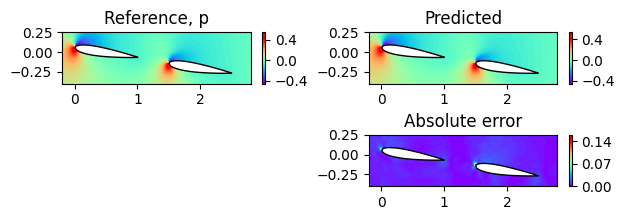

In [35]:
# plot
cfd, pinn = data_Y[:,2], p.flatten()
fig = plt.figure(figsize=(7, 2))
fig.subplots_adjust(wspace=.3, hspace=1.)
con_lv = 101
ax1 = fig.add_subplot(2,2,1)
plt.tricontourf(data_X[:,0], data_X[:,1], cfd, con_lv, origin='lower', cmap='rainbow', vmin=-0.4, vmax=0.4);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)  
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Reference, p');
plt.colorbar(ticks=[-0.4, 0, 0.4]);
ax1 = fig.add_subplot(2,2,2)
plt.tricontourf(data_X[:,0], data_X[:,1], pinn, con_lv, origin='lower', cmap='rainbow', vmin=-0.4, vmax=0.4);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Predicted');
plt.colorbar(ticks=[-0.4, 0, 0.4]);
ax1 = fig.add_subplot(2,2,4)
plt.tricontourf(data_X[:,0], data_X[:,1], abs(cfd - pinn), con_lv, origin='lower', cmap='rainbow', vmin=0, vmax=0.14);
plt.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(), color='white', edgecolor='black', linewidth=1.)  
plt.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(), color='white', edgecolor='black', linewidth=1.) 
plt.xlim(-0.2, 2.8); plt.ylim(-0.4, 0.25); plt.title('Absolute error');
plt.colorbar(ticks=[0, 0.07, 0.14]);

Near field + streamline

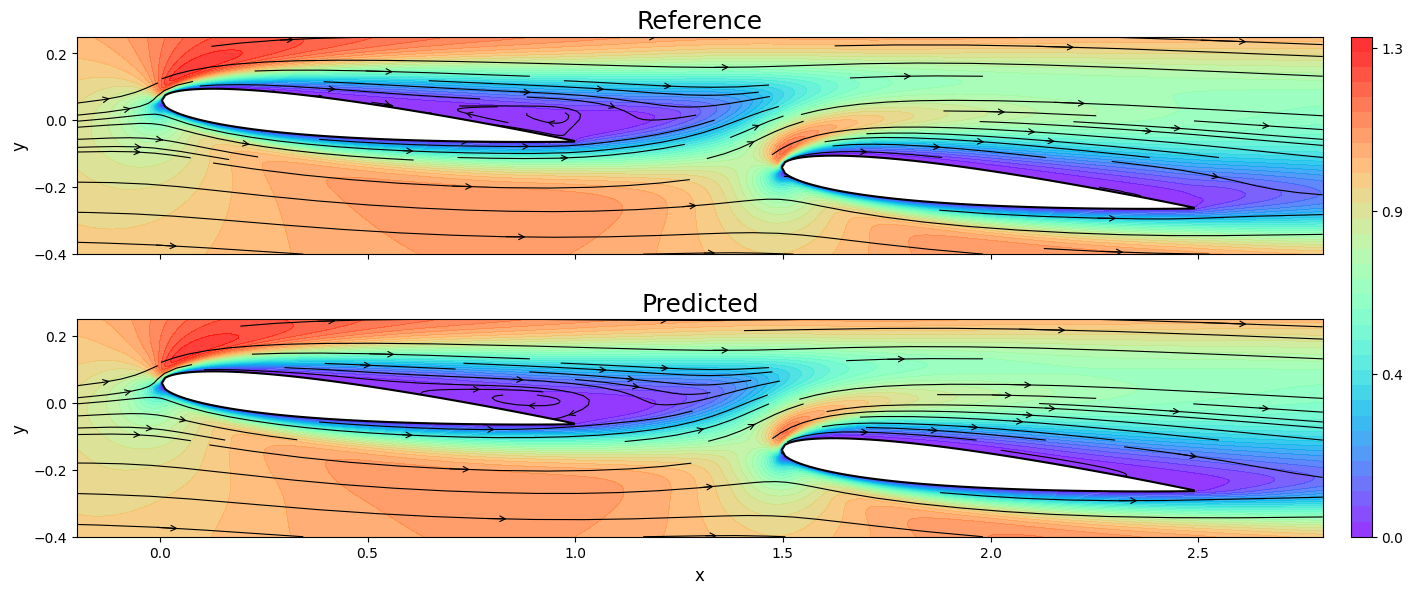

In [33]:
from scipy.interpolate import griddata

# grid
test_x = np.linspace(-0.2, 2.8, 1000)
test_y = np.linspace(-0.4, 0.25, 500)
test_X, test_Y = np.meshgrid(test_x, test_y)
test_inputs = np.hstack([test_X.reshape(-1, 1), test_Y.reshape(-1, 1)])
test_inputs_jax = jnp.array(test_inputs)

# pinn
test_uvp = model.apply(params, test_inputs_jax)
pre_u = np.array(test_uvp[:, 0]).reshape(test_X.shape)
pre_v = np.array(test_uvp[:, 1]).reshape(test_X.shape)
pre_V = np.sqrt(pre_u**2 + pre_v**2)

# cfd
data_u = data_Y[:, 0]
data_v = data_Y[:, 1]
cfd_u = griddata(data_X, data_u, test_inputs, method='cubic')
cfd_v = griddata(data_X, data_v, test_inputs, method='cubic')
cfd_u = np.nan_to_num(cfd_u, nan=0.0).reshape(test_X.shape)
cfd_v = np.nan_to_num(cfd_v, nan=0.0).reshape(test_X.shape)
cfd_V = np.sqrt(cfd_u**2 + cfd_v**2)

# template
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 5), sharex=True, sharey=True)
fig.subplots_adjust(left=0, right=0.89, top=1, bottom=0, hspace=0.3)

titles = ['Reference', 'Predicted']
u_list = [cfd_u, pre_u]
v_list = [cfd_v, pre_v]

V_list = [np.where(cfd_V > 1.29, np.nan, cfd_V),
          np.where(pre_V > 1.29, np.nan, pre_V)]

vmin = np.nanmin([np.nanmin(cfd_V), np.nanmin(pre_V)])
vmax = 1.29
tick_vals = np.linspace(vmin, vmax, 4)
tick_labels = [f'{val:.1f}' for val in tick_vals]

cmap = plt.cm.rainbow
cmap.set_bad(color='white') 

# plot
for i in range(2):
    ax = axs[i]
    test_u, test_v, test_V = u_list[i], v_list[i], V_list[i]
    bg = ax.contourf(test_X, test_Y, test_V, levels=35, cmap=cmap, alpha=0.8,
                     vmin=vmin, vmax=vmax, zorder=0)
    # sparse
    sparse_mask = (test_Y > 0.12) | (test_Y < -0.12) | ((test_Y < -0.12) & (test_X < 1.)) | ((test_Y > 0.) & (test_X > 1.5))
    u_sparse = np.where(sparse_mask, test_u, np.nan)
    v_sparse = np.where(sparse_mask, test_v, np.nan)
    ax.streamplot(test_x, test_y, u_sparse, v_sparse,
                  color='k', linewidth=0.8, density=0.4,
                  arrowsize=1., arrowstyle='->', zorder=1)
    # dense
    dense_mask = ~sparse_mask 
    u_dense = np.where(dense_mask, test_u, np.nan)
    v_dense = np.where(dense_mask, test_v, np.nan)
    ax.streamplot(test_x, test_y, u_dense, v_dense,
                  color='k', linewidth=0.8, density=1.25,
                  arrowsize=1., arrowstyle='->', zorder=1)
    # foil
    ax.fill_between(naca0012_x_rot.flatten(), y_upper_rot.flatten(), y_lower_rot.flatten(),
                    color='white', edgecolor='black', linewidth=1.5)
    ax.fill_between(naca0012_x_rot2.flatten(), y_upper_rot2.flatten(), y_lower_rot2.flatten(),
                    color='white', edgecolor='black', linewidth=1.5)
    ax.set_xlim(-0.2, 2.8); ax.set_ylim(-0.25, 0.25);
    ax.set_xticks(np.linspace(-0., 2.5, 6)); ax.set_yticks(np.linspace(-0.4, 0.2, 4));
    ax.set_title(titles[i], fontsize=18)

# label
axs[1].set_xlabel('x', fontsize=12)
axs[1].set_ylabel('y', fontsize=12)
axs[0].set_ylabel('y', fontsize=12)

# colorbar
cbar_ax = fig.add_axes([0.91, 0., 0.015, 1.]); # [left, bottom, width, height]
cbar = fig.colorbar(bg, cax=cbar_ax, ticks=tick_vals);
cbar.ax.set_yticklabels(tick_labels);
cbar.ax.tick_params(labelsize=10);